In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [2]:
universe = Q1500US()
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [3]:
study_date = "2018-12-31"
res = run_pipeline(pipe, study_date, study_date)
#res.index = res.index.droplevel(0) 

In [4]:
res

Financial Health  Industry  \
2018-12-31 00:00:00+00:00 Equity(2 [ARNC])                      C     31061   
                          Equity(24 [AAPL])                     B     31167   
                          Equity(52 [ABM])                      C     31054   
                          Equity(53 [ABMD])                     A     20639   
                          Equity(62 [ABT])                      A     20639   
                          Equity(67 [ADSK])                     B     31165   
                          Equity(76 [TAP])                      C     20529   
                          Equity(110 [RAMP])                    B     31165   
                          Equity(114 [ADBE])                    A     31165   
                          Equity(122 [ADI])                     B     31169   
                          Equity(128 [ADM])                     B     20531   
                          Equity(161 [AEP])                     A     20744   
                          Equity(166 [AES])                     C     20744   
                          Equity(185 [AFL])                     C     10324   
                          Equity(197 [AGCO])                    C     31059   
                          Equity(216 [HES])                     C     30947   
                          Equity(239 [AIG])                     C     10323   
                          Equity(266 [AJG])                     B     10321   
                          Equity(300 [ALK])                     C     31053   
                          Equity(301 [ALKS])                    C     20635   
                          Equity(337 [AMAT])                    C     31169   
                          Equity(351 [AMD])                     C     31169   
                          Equity(353 [AME])                     A     31061   
                          Equity(368 [AMGN])                    B     20635   
                          Equity(371 [TVTY])                    B     20638   
                          Equity(405 [AMWD])                    C     10212   
                          Equity(410 [AN])                      C     10209   
                          Equity(438 [AON])                     A     10321   
                          Equity(448 [APA])                     C     30947   
                          Equity(455 [APC])                     C     30947   
...                                                           ...       ...   
                          Equity(51651 [COLD])                  B     10428   
                          Equity(51689 [PAGS])                  C     31165   
                          Equity(51734 [VICI])                  C     10428   
                          Equity(51742 [WHD])                None     30951   
                          Equity(51815 [GLIB_A])                B     30845   
                          Equity(51832 [ZS])                    C     31165   
                          Equity(51854 [DBX])                   C     31165   
                          Equity(51895 [SPOT])                  B     31168   
                          Equity(51917 [ZUO])                   C     31165   
                          Equity(51928 [NVT])                   B     31167   
                          Equity(51934 [EAF])                   C     31061   
                          Equity(51937 [DOCU])                  D     31165   
                          Equity(51942 [PVTL])                  C     31165   
                          Equity(51955 [CDAY])                  C     31165   
                          Equity(51966 [APY])                   C     30951   
                          Equity(51987 [AMRX])               None     20636   
                          Equity(51992 [PS])                    C     31165   
                          Equity(51994 [EQH])                   D     10323   
                          Equity(52028 [WH])                    B     10218   
                    

In [5]:
res.index = res.index.droplevel(0)

In [6]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1485, 3)


In [7]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1482, 3)


In [8]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [9]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)

In [10]:
pricing.head()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(110 [RAMP]),Equity(114 [ADBE]),Equity(122 [ADI]),...,Equity(52045 [PRSP]),Equity(52064 [EVRG]),Equity(52084 [VNE]),Equity(52100 [AVLR]),Equity(52159 [BJ]),Equity(52211 [TLRY]),Equity(52291 [SONO]),Equity(52361 [BPR]),Equity(52424 [ELAN]),Equity(52592 [LIN])
2017-01-03 00:00:00+00:00,18.794,112.611,39.481,112.37,37.459,76.17,93.776,26.46,103.48,69.525,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04 00:00:00+00:00,19.284,112.495,40.091,115.74,37.718,77.51,95.251,26.86,104.13,69.391,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05 00:00:00+00:00,19.675,113.067,39.249,114.71,38.102,76.93,95.500,26.98,105.91,68.384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06 00:00:00+00:00,20.273,114.328,38.485,115.33,39.138,79.30,95.644,26.94,108.30,68.662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-09 00:00:00+00:00,19.979,115.385,38.118,117.11,39.109,79.59,94.188,26.52,108.57,68.979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
res.index

Index([    Equity(2 [ARNC]),    Equity(24 [AAPL]),     Equity(52 [ABM]),
          Equity(53 [ABMD]),     Equity(62 [ABT]),    Equity(67 [ADSK]),
           Equity(76 [TAP]),   Equity(110 [RAMP]),   Equity(114 [ADBE]),
          Equity(122 [ADI]),
       ...
       Equity(52045 [PRSP]), Equity(52064 [EVRG]),  Equity(52084 [VNE]),
       Equity(52100 [AVLR]),   Equity(52159 [BJ]), Equity(52211 [TLRY]),
       Equity(52291 [SONO]),  Equity(52361 [BPR]), Equity(52424 [ELAN]),
        Equity(52592 [LIN])],
      dtype='object', length=1482)

In [12]:
returns = pricing.pct_change()

In [13]:
returns = returns.iloc[1:,:].dropna(axis=1)

In [14]:
returns

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(114 [ADBE]),Equity(122 [ADI]),Equity(128 [ADM]),...,Equity(50399 [IRTC]),Equity(50400 [CRSP]),Equity(50418 [BL]),Equity(50428 [AA]),Equity(50430 [LW]),Equity(50518 [ATH]),Equity(50533 [CNDT]),Equity(50534 [HGV]),Equity(50535 [PK]),Equity(50537 [WRD])
2017-01-04 00:00:00+00:00,0.026072,-0.001030,0.015450,0.029990,0.006914,0.017592,0.015729,0.006281,-0.001927,-0.001932,...,0.000000,0.031376,-0.008621,0.049271,-0.016282,0.005658,0.001448,0.009386,-0.019439,0.003439
2017-01-05 00:00:00+00:00,0.020276,0.005085,-0.021002,-0.008899,0.010181,-0.007483,0.002614,0.017094,-0.014512,-0.007395,...,-0.008040,-0.002173,-0.024275,0.013228,-0.007034,-0.016462,0.022415,-0.008911,-0.047110,-0.006169
2017-01-06 00:00:00+00:00,0.030394,0.011153,-0.019465,0.005405,0.027190,0.030807,0.001508,0.022566,0.004065,-0.022514,...,0.013171,-0.023519,0.004827,0.001305,0.004919,-0.001483,0.044554,0.038311,0.022936,-0.017241
2017-01-09 00:00:00+00:00,-0.014502,0.009245,-0.009536,0.015434,-0.000741,0.003657,-0.015223,0.002493,0.004617,0.000902,...,0.050000,0.015611,0.004804,-0.039113,0.002154,-0.003395,-0.052133,-0.002636,0.014495,0.018246
2017-01-10 00:00:00+00:00,0.015216,0.000919,0.004040,-0.041585,0.013015,0.004900,-0.019132,-0.002763,0.005973,-0.006690,...,0.002540,0.009662,-0.016550,0.051221,-0.001898,-0.004471,-0.042143,-0.021895,0.002366,-0.000689
2017-01-11 00:00:00+00:00,0.018340,0.005290,0.016435,-0.008642,0.001590,0.011128,-0.008086,0.006742,0.003588,-0.010246,...,-0.013300,-0.026098,-0.000374,0.031623,0.001370,-0.018178,-0.006711,-0.016017,0.005791,0.034483
2017-01-12 00:00:00+00:00,-0.004260,-0.004091,-0.011182,0.010245,-0.009022,-0.002968,-0.002204,-0.003761,-0.005643,-0.012620,...,-0.010911,-0.012059,-0.007856,0.033156,0.001620,0.006535,0.048799,-0.003726,-0.014526,-0.011333
2017-01-13 00:00:00+00:00,0.005689,-0.001764,0.017860,0.028823,0.005417,0.008558,0.023065,-0.000553,0.006369,0.002542,...,-0.008436,-0.044756,0.013952,-0.000303,0.008392,0.016014,0.001432,-0.013780,-0.005797,-0.005394
2017-01-17 00:00:00+00:00,-0.017501,0.007979,-0.017061,-0.014527,-0.000986,-0.033202,0.002865,-0.004883,-0.005367,0.025937,...,-0.029450,0.022243,-0.003719,-0.011508,-0.007825,-0.020234,0.014296,-0.001996,0.004204,0.005424
2017-01-18 00:00:00+00:00,0.006741,0.000000,0.000754,-0.006493,-0.003899,0.013991,0.002963,0.007315,0.010099,0.005703,...,-0.007755,0.027778,0.013438,0.066483,-0.007273,0.003913,0.023256,0.006400,-0.006842,-0.006069


In [15]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [16]:
pca.components_.T.shape

(1376, 50)

In [17]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

In [18]:
X = preprocessing.StandardScaler().fit_transform(X) #normalize X

In [19]:
clf = DBSCAN(eps=1.8, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.8, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 14


In [20]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 946000 


In [21]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [22]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 14
Pairs to evaluate: 1764


In [23]:
#visualization
X_tsne = TSNE(learning_rate=1000, perplexity=22, random_state=1337).fit_transform(X)

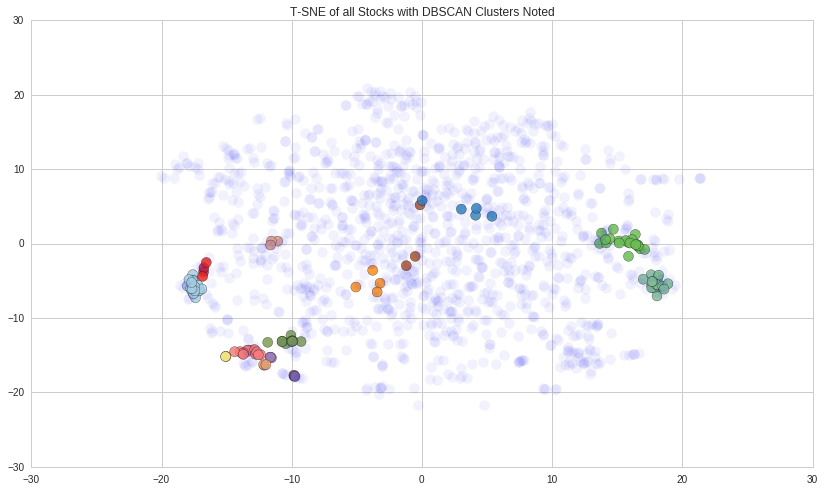

In [24]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis()

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted')

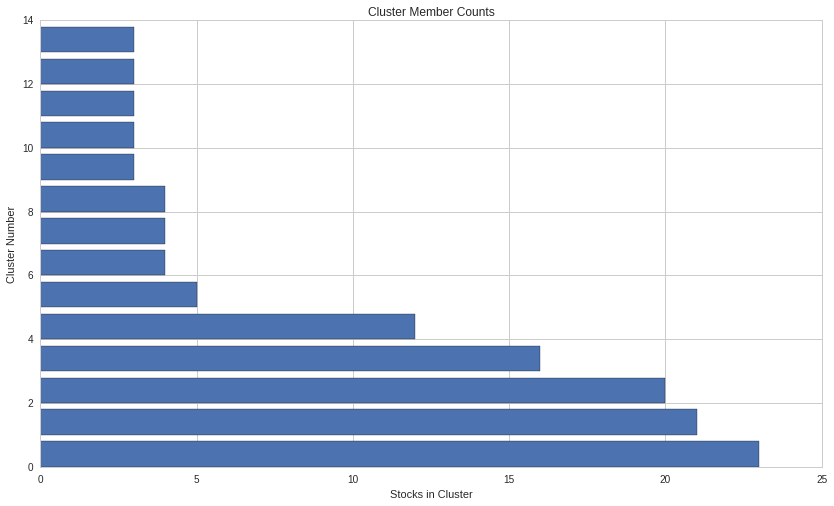

In [25]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');


In [26]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


In [27]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]


Equity(700 [BAC])       3
Equity(903 [BK])        3
Equity(1335 [C])        3
Equity(1620 [CMA])      3
Equity(2855 [FITB])     3
Equity(3472 [HBAN])     3
Equity(4221 [KEY])      3
Equity(5117 [MTB])      3
Equity(5479 [NTRS])     3
Equity(6068 [PNC])      3
Equity(7152 [STI])      3
Equity(8151 [WFC])      3
Equity(8399 [ZION])     3
Equity(16850 [BBT])     3
Equity(17080 [MS])      3
Equity(19787 [EWBC])    3
Equity(20088 [GS])      3
Equity(25006 [JPM])     3
Equity(25010 [USB])     3
Equity(34913 [RF])      3
Equity(47777 [CFG])     3
dtype: int64

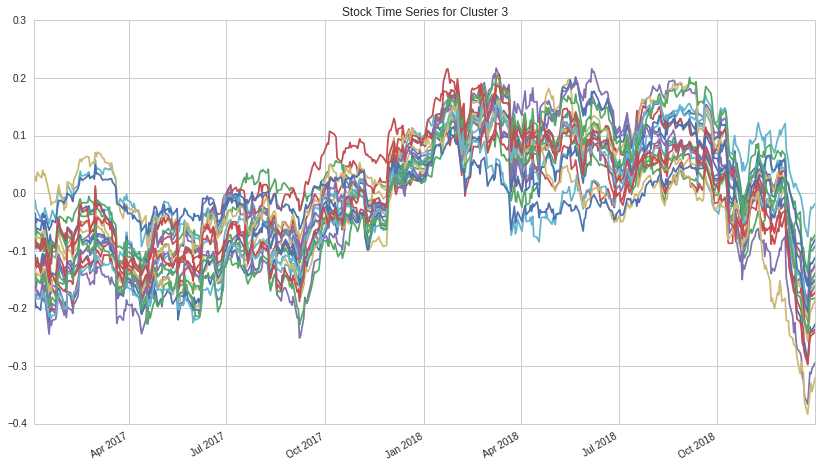

In [28]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

In [29]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [30]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [31]:
pairs

[(Equity(161 [AEP]), Equity(2330 [DTE])),
 (Equity(161 [AEP]), Equity(5484 [ES])),
 (Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(612 [ATO]), Equity(3798 [IDA])),
 (Equity(612 [ATO]), Equity(24783 [AEE])),
 (Equity(2330 [DTE]), Equity(5484 [ES])),
 (Equity(2330 [DTE]), Equity(21964 [XEL])),
 (Equity(2637 [ETR]), Equity(36098 [AWK])),
 (Equity(5310 [NI]), Equity(24064 [CNP])),
 (Equity(8140 [WEC]), Equity(24783 [AEE])),
 (Equity(8140 [WEC]), Equity(36098 [AWK])),
 (Equity(24064 [CNP]), Equity(24783 [AEE])),
 (Equity(1023 [BOH]), Equity(3476 [HWC])),
 (Equity(1023 [BOH]), Equity(7007 [SNV])),
 (Equity(1023 [BOH]), Equity(8011 [VLY])),
 (Equity(1023 [BOH]), Equity(26204 [FHN])),
 (Equity(1023 [BOH]), Equity(27421 [WAL])),
 (Equity(1028 [BXS]), Equity(7007 [SNV])),
 (Equity(1028 [BXS]), Equity(27421 [WAL])),
 (Equity(2701 [FNB]), Equity(26204 [FHN])),
 (Equity(3066 [FULT]), Equity(3476 [HWC])),
 (Equity(3066 [FULT]), Equity(5639 [ONB])),
 (Equity(3066 [FULT]), Equity(7007 [SNV])),
 (E

In [32]:
print "We found %d pairs." % len(pairs)

We found 58 pairs.


In [33]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 59 unique tickers.


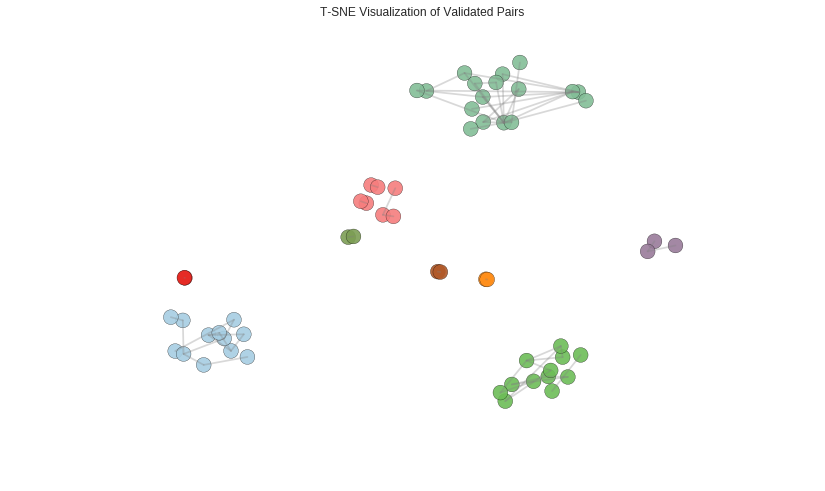

In [34]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');